# CmpE547 HW2 - Generative Models

## Objectives

1. Visualize the given dataset using a scatter plot
2. Propose a generative model 
3. Implement your generative model and sample data from your model 
4. Visualize synthetic data to show that your model generates a 'similar dataset' 
5. How can you assess if two datasets are similar? Discuss

In [74]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import i0
from IPython.display import display, Math, Latex
import seaborn as sns
import pandas as pd


def pnorm_ball_points(A=np.eye(2), mu=np.array([0,0]),p=2, N=128):
    '''
    Creates the points on a p normball y = A x + \mu 
    where x are points on the unit circle.
    '''
    if p is np.infty:
    	X = np.array([[1,1],[1,-1],[-1,-1],[-1,1],[1,1]]).T
    else:
	    th = np.arange(0, 2*np.pi+np.pi/N, np.pi/N)
	    X = np.array([np.cos(th),np.sin(th)])
	    X = X*(1/(np.abs(X[0,:])**p + np.abs(X[1,:])**p ))**(1/p)


    Y = np.dot(A, X)
    data_x = mu[0]+Y[0,:]
    data_y = mu[1]+Y[1,:]
    return data_x, data_y

def mat2latex(a,dollar=False):
    """Returns a LaTeX string for typesetting a matrix
    :a: numpy array
    :returns: LaTeX string
    """
    if len(a.shape) > 2:
        raise ValueError('mat2latex can display only matrices or vectors')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\left(\begin{array}{cc}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{array}\right)']
    if dollar:
        return '$'.join(rv)+'$'		
    else:
        return ''.join(rv)




#### 1. Visualize the give dataset using a scatter plot

* Reads data from "input.txt" and then visualizes it.

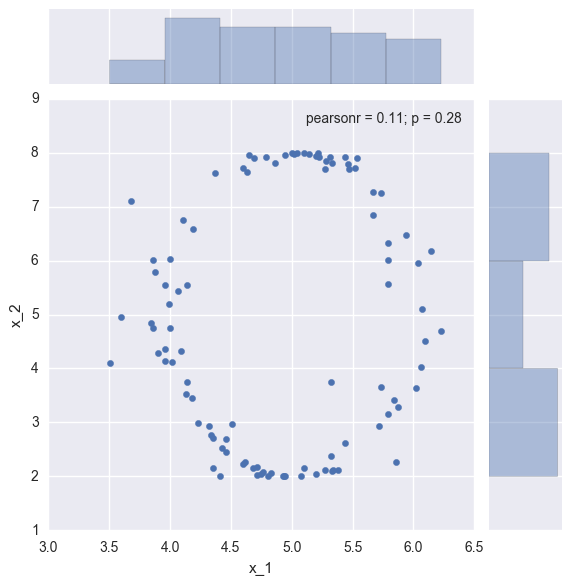

In [81]:
file = open("input.txt", 'r')

lines = file.readlines()

X1 = []
X2 = []

for line in lines:
    X1.append(line.split()[0])
    X2.append(line.split()[1])


X = np.zeros((2,100))

for i in range(len(X1)):
    X[0,i] = X1[i]
    
for i in range(len(X1)):
    X[1,i] = X2[i]


#plt.figure(figsize=(6,6))
#plt.plot(X[0,:],X[1,:],'k.')

#plt.show()   
    
sns.set(color_codes=True)
plt.figure(figsize=(5,5))
df = pd.DataFrame(X.T, columns=['x_1','x_2'])
sns.jointplot(x="x_1", y="x_2", data=df);
plt.show()

#### 2. Propose a generative model 

* The proposed generative model

\begin{eqnarray}
w & \sim & \mathcal{U}(0,1) \\
u_1 & = & \cos(2\pi w) \\
u_2 & = & \sin(2\pi w) \\
e_1 & \sim & \mathcal{N}\left(0, (\sigma u_1)^2 \right) \\
e_2 & \sim & \mathcal{N}\left(0, (\sigma u_2)^2 \right) \\
x_1 & \sim & \left(\theta_1 \right)u_1 + c + e_1 \\
x_2 & \sim & \left(\theta_2 \right)u_2 + c
\end{eqnarray}

#### 3. Implement your generative model and sample data from your model 

* Implementation of the proposed generative model.
* Visualization of the data that is sampled from the proposed generative model.

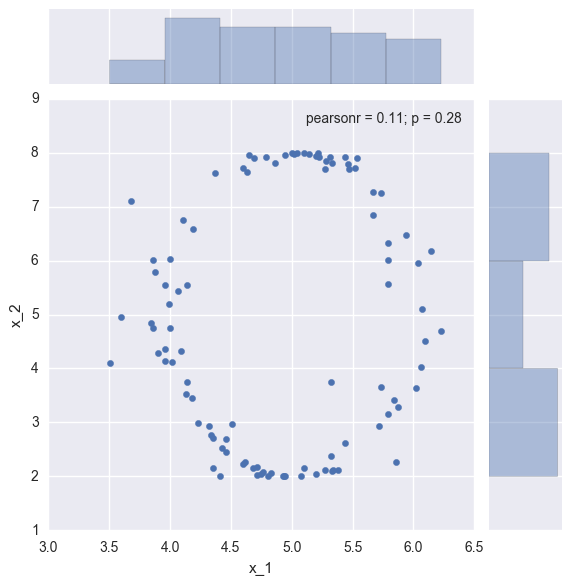

In [99]:
# radius of the circle
theta1 = 1
theta2 = 3
# center of the circle (x, y)
c = 5

N = 100

t = np.random.rand(N)

cost = np.cos( 2 * np.pi * t)
sint = np.sin( 2 * np.pi * t)

x1 = 1 * cost + 5
x2 = 3 * sint + 5

x1 = x1 + 0.2*cost*np.random.randn(N)
# x2 = x2 + 0.3*sint*np.random.randn(N)

sns.set(color_codes=True)
plt.figure(figsize=(5,5))
df = pd.DataFrame(X.T, columns=['x_1','x_2'])
sns.jointplot(x="x_1", y="x_2", data=df);
plt.show()




* Useful metrics to understand data and the model. Also we can observe some obvious differences if there is any.

True Covariance


<IPython.core.display.Math object>

<IPython.core.display.Math object>

The ML Estimates from Data


<IPython.core.display.Math object>

<IPython.core.display.Math object>

The estimate when we assume that we know the true mean


<IPython.core.display.Math object>

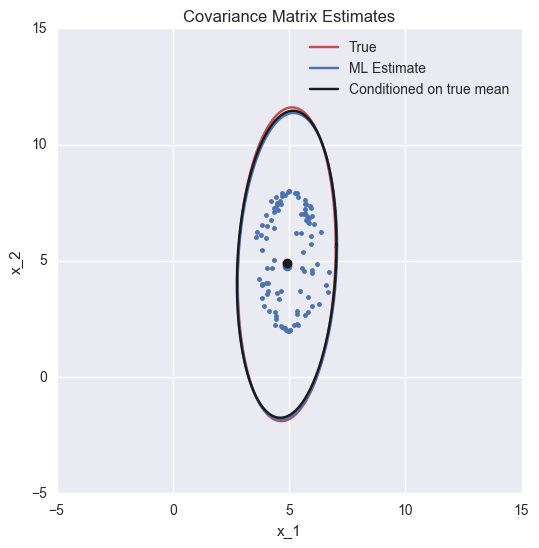

In [100]:
A = np.c_[X[0,:],X[1,:]].T

print('True Covariance')
mean = np.mean(A,axis=1,keepdims=True)
Cov = np.cov(A,bias=True)

display(Math(r'\mu='+mat2latex(mean)))
display(Math(r'\Sigma='+mat2latex(Cov)))

A = np.c_[x1,x2].T

print('The ML Estimates from Data')
mean_est = np.mean(A,axis=1,keepdims=True)
cov_est = np.cov(A,bias=True)
display(Math(r'\bar{m}='+mat2latex(mean_est)))
display(Math(r'\bar{S}='+mat2latex(cov_est)))


print('The estimate when we assume that we know the true mean')
cov2_est = (A-mean).dot((A-mean).T)/N
display(Math(r'\bar{\Sigma}='+mat2latex(cov2_est)))

plt.figure(figsize=(6,6))
plt.plot(x, y, '.')
ax = plt.gca()
ax.axis('equal')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')

# True mean and Covariance
dx,dy = pnorm_ball_points(3*np.linalg.cholesky(Cov), mu=mean)
ln = plt.Line2D(dx,dy, color='r')
ln.set_label('True')
ax.add_line(ln)
ln = plt.Line2D(mean[0],mean[1], color='r', marker='o')
ax.add_line(ln)

dx,dy = pnorm_ball_points(3*np.linalg.cholesky(cov_est), mu=mean_est)
ln = plt.Line2D(dx,dy, color='b')
ln.set_label('ML Estimate')
ax.add_line(ln)
ln = plt.Line2D(mean_est[0],mean_est[1], color='b', marker='o')
ax.add_line(ln)

# Estimate conditioned on knowing the true mean
dx,dy = pnorm_ball_points(3*np.linalg.cholesky(cov2_est), mu=mean)
ln = plt.Line2D(dx,dy, color='k')
ln.set_label('Conditioned on true mean')
ax.add_line(ln)
ln = plt.Line2D(mean[0],mean[0], color='k', marker='o')
ax.add_line(ln)

Lim = 10
ax.set_ylim([-Lim+5,Lim+5])
ax.set_xlim([-Lim+5,Lim+5])

ax.legend()
plt.title('Covariance Matrix Estimates')
plt.show()



#### 4. Visualize synthetic data to show that your model generates a 'similar dataset'

* I used Bootstrap method to create syntetic data.
* Compared synthetic data with the real data on the graph by using covariance estimates.

##### 4.1 Bootstrap

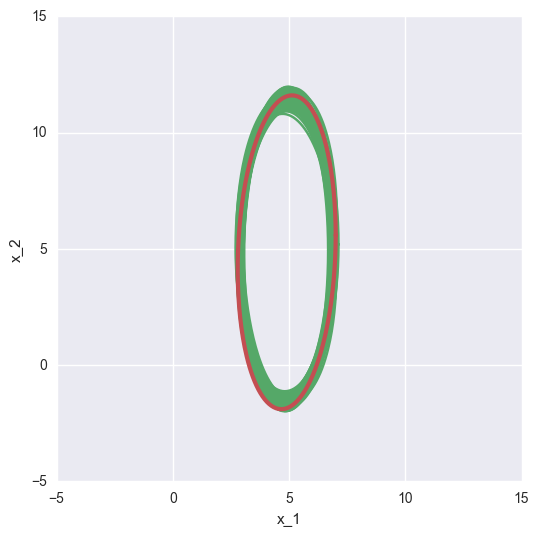

In [114]:
EPOCH = 100
M = N

t = np.random.rand(N+M)
cost = np.cos( 2 * np.pi * t)
sint = np.sin( 2 * np.pi * t)
x1 = 1 * cost + 5
x2 = 3 * sint + 5
x1 = x1 + 0.2*cost*np.random.randn(N+M)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
Lim =10
ax.set_ylim([-Lim+5,Lim+5])
ax.set_xlim([-Lim+5,Lim+5])

for i in range(EPOCH):
    idx = np.random.permutation(N+M)
    A = np.c_[x1[idx[0:N]],x2[idx[0:N]]].T
    mean_est = np.mean(A,axis=1,keepdims=True)
    cov2_est = (A-mean_est).dot((A-mean_est).T)/N
    dx,dy = pnorm_ball_points(3*np.linalg.cholesky(cov2_est), mu=mean_est)
    ln = plt.Line2D(dx,dy, color='g')
    ax.add_line(ln)

dx,dy = pnorm_ball_points(3*np.linalg.cholesky(Cov), mu = mean)
ln = plt.Line2D(dx,dy, color='r', linewidth=3)
ax.add_line(ln)

plt.show()

#### 5. How can you assess if two datasets are similar? Discuss

* Every green ellipse on the upper graph corresponds to an estimated covariance $\Sigma^{(i)}$ from each new dataset $X^{(i)}$ sampled from the data distribution.
* We can check the upper graph and check wether the true covariance ellipse is the average of the estimated covariance ellipses or not.
* The graph suggests that the true covariance could be somehow obtained as the average ellipse. So we can say that our generative model sampled similar dataset to the original dataset.

#### Bonus: Bayesian Approach


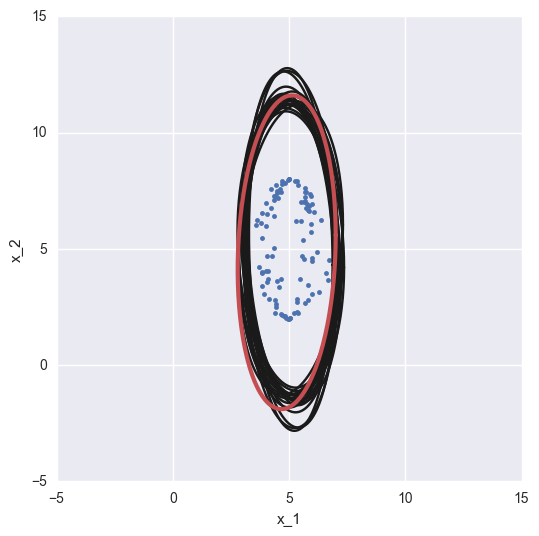

In [117]:
EPOCH = 20

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
Lim =10
ax.set_ylim([-Lim+5,Lim+5])
ax.set_xlim([-Lim+5,Lim+5])

t = np.random.rand(N)
cost = np.cos( 2 * np.pi * t)
sint = np.sin( 2 * np.pi * t)
x1 = 1 * cost + 5
x2 = 3 * sint + 5
x1 = x1 + 0.2*cost*np.random.randn(N)

A = np.c_[x1,x2].T
mean_est = np.mean(A,axis=1,keepdims=True)
cov2_est = (A-mean_est).dot((A-mean_est).T)/N
W = np.linalg.cholesky(cov2_est)

plt.plot(x,y,'.')

for i in range(EPOCH):
    U = W.dot(np.random.randn(2,N))
    S = U.dot(U.T)/N
    dx,dy = pnorm_ball_points(3*np.linalg.cholesky(S), mu = mean_est)
    ln = plt.Line2D(dx,dy, color='k')
    ax.add_line(ln)

dx,dy = pnorm_ball_points(3*np.linalg.cholesky(Cov), mu = mean)
ln = plt.Line2D(dx,dy, color='r', linewidth=3)
ax.add_line(ln)

plt.show()